In [1]:
#Import pandas, matplotlib.pyplot, and seaborn 
import pandas as pd
import numpy as np
import math
import missingno as msno
import datetime as dt
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_profiling
from pandas_profiling.utils.cache import cache_file

import calendar
from scipy.signal import argrelextrema


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.api as sm

import lightgbm
from bayes_opt import BayesianOptimization

In [2]:
data = pd.read_excel('data2017_2020.xlsx')
print(data.shape)
data.head()

(412, 5)


RATE month_start  DWEL_UNIT  days_to_count_in_period  \
0  COM  2016-04-01          1                       19   
1  COM  2016-05-01          1                       12   
2  COM  2016-11-01          3                       56   
3  COM  2016-12-01          4                       62   
4  COM  2017-01-01          5                       69   

   usage_to_count_in_period  
0                       1.4  
1                       0.5  
2                       5.7  
3                       6.7  
4                       8.4

**During data wrangling, I separated Pure Commercial from Commercial and Residential customers to correct**
**the number of dwelling and know the percentage of pure commercial customers in commercial group.**

**High proportion of commercial customers are pure commercial. Now for exploration and modling, I merge these subgroups**
**as commercial group.**

In [3]:
data.RATE = data.RATE.replace({'COM&RES':'COM'})

data = data.groupby(['RATE', 'month_start'])[['DWEL_UNIT','usage_to_count_in_period']].\
    sum().reset_index()
data.columns = ['RATE', 'month_start', 'DWEL_UNIT','usage']
print(data.shape)
data.head()

(270, 4)


RATE month_start  DWEL_UNIT  usage
0  COM  2016-04-01          2    6.1
1  COM  2016-05-01          1    0.5
2  COM  2016-11-01          3    5.7
3  COM  2016-12-01          4    6.7
4  COM  2017-01-01          5    8.4

In [4]:
#Filter water usage for Jul-2017 to Jul-2020
data = data[(data.month_start > '2017-7-01') & (data.month_start < '2020-07-01')]
data.shape

(210, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210 entries, 11 to 267
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RATE         210 non-null    object        
 1   month_start  210 non-null    datetime64[ns]
 2   DWEL_UNIT    210 non-null    int64         
 3   usage        210 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 8.2+ KB


In [6]:
data['year']= data.month_start.dt.year
data['month'] = data.month_start.dt.month
data.head()

RATE month_start  DWEL_UNIT     usage  year  month
11  COM  2017-08-01      11933  517040.4  2017      8
12  COM  2017-09-01      11837  444599.4  2017      9
13  COM  2017-10-01      13028  483258.2  2017     10
14  COM  2017-11-01      11916  411534.7  2017     11
15  COM  2017-12-01      11998  404455.6  2017     12

In [7]:
#Create list of years
years = list(data.year.unique())

#Calculate % of dwelling in each year for each segment
dwelling = data.groupby(['year','RATE'])['DWEL_UNIT'].sum()
dwelling = dwelling.to_frame().reset_index()
dwelling.columns= ['year','RATE','Number_of_dwellings']

dwelling_per_yr = data.groupby('year')['DWEL_UNIT'].sum()

for yr in years:
    dwelling.loc[dwelling.year == yr ,'pct_of_dwellings'] =\
    round(100*dwelling.loc[dwelling.year == yr, 'Number_of_dwellings'] /(dwelling_per_yr[yr]),1)
    
dwelling= dwelling.sort_values(by= ['year','pct_of_dwellings'] , ascending=[True,False])
dwelling.head()

year    RATE  Number_of_dwellings  pct_of_dwellings
4  2017     RMF               825648              53.9
5  2017    RSFD               500523              32.6
3  2017  RDUPLX               133972               8.7
0  2017     COM                60712               4.0
2  2017     IRR                10460               0.7

In [8]:
#Create profiling report
report = data.profile_report(sort='None', html={'style':{'full_width': True}}, progress_bar=False)

#Save report to file
report.to_file(output_file= "usage_report.html")

In [9]:
import plotly.express as px
import plotly.io as pio

pio.templates.default = "simple_white"

dwelling.year= dwelling.year.astype('str')

dwelling.RATE.replace ({'RMF':'Multi_family','RSFD':'Singel_family',\
                        'RDUPLX':'Duplex', 'COM':'Commercial', 'IRR':'Irrigation', 'IND':'Industrial'}, inplace= True)


fig= px.bar(y= dwelling.RATE, x= dwelling.pct_of_dwellings, color= dwelling.year,\
           hover_name = dwelling.pct_of_dwellings,
           title= '% of Dwellings in Different Segments')
          
fig.update_yaxes(categoryorder='total descending', title='') 
fig.update_xaxes(title='') 


fig.update_layout(title_font_size= 25, title_font_color='purple')


fig.data[-1].text= dwelling.loc[dwelling.year=='2020','pct_of_dwellings']
fig.update_traces(textposition='inside')

fig.data[-2].text= dwelling.loc[dwelling.year=='2019','pct_of_dwellings']
fig.update_traces(textposition='inside')

fig.data[-3].text= dwelling.loc[dwelling.year=='2018','pct_of_dwellings']
fig.update_traces(textposition='inside')

fig.data[-4].text= dwelling.loc[dwelling.year=='2017','pct_of_dwellings']
fig.update_traces(textposition='inside')

#Add a text callout with arrow
fig.add_annotation(text= 'Each Year 0.12%', y= 'Industrial',x=0.2)

fig.show()

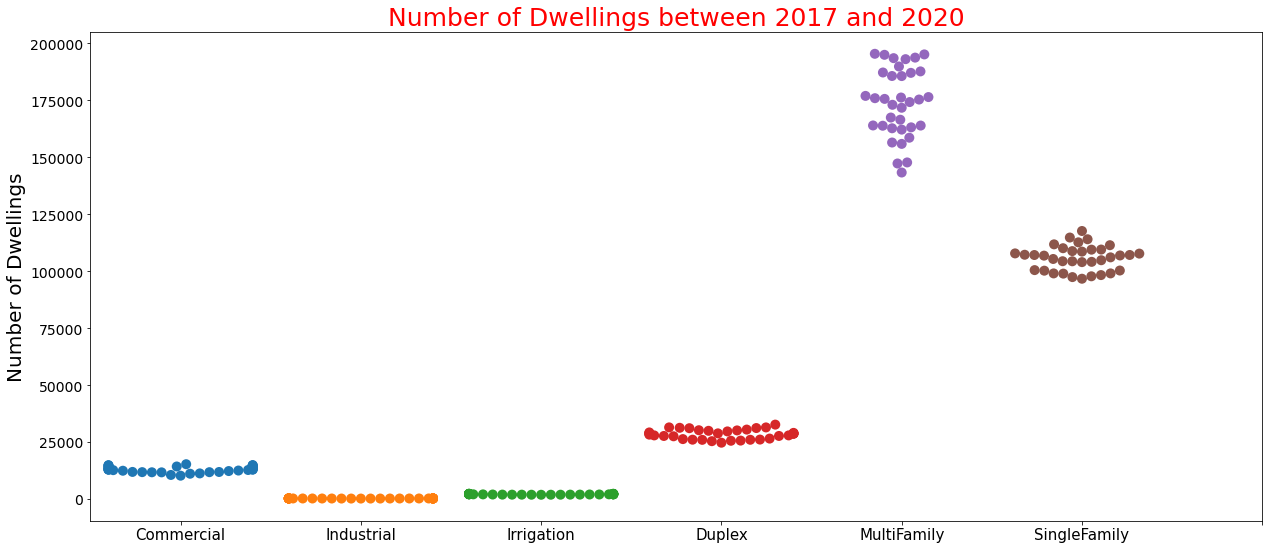

In [10]:
#Plot the range of number of dwellings in different customer groups
plt.figure(figsize=(21,9))

sns.swarmplot(x= data.RATE, y= data.DWEL_UNIT, size= 10)
plt.xticks(ticks=list(range(7)), labels=['Commercial','Industrial', 'Irrigation' ,\
                                         'Duplex', 'MultiFamily', 'SingleFamily'], fontsize=15)
plt.yticks(fontsize=14)
plt.xlabel('')
plt.ylabel('Number of Dwellings', fontsize=20)
plt.title('Number of Dwellings between 2017 and 2020',\
          fontsize=25, color='red')
plt.show()

**High number of dwellings are related to Multi-Family and Single Family segments which makes sense, so the high value of dwellings
are not outliers.**

In [11]:
#Create list of years
years = list(data.year.unique())

#Calculate usage per year for each rate
annual_usge_per_rate= data.groupby(['year','RATE'])['usage'].sum().reset_index()
 

#Calculate percentage of usage per year for each rate
usage_per_year = data.groupby('year')['usage'].sum()
for yr in years:
    annual_usge_per_rate.loc[annual_usge_per_rate.year == yr, 'pct_usage']=\
    round(100 * (annual_usge_per_rate.loc[annual_usge_per_rate['year']==yr, 'usage'] /usage_per_year[yr]),2)

annual_usge_per_rate.head()

    

year    RATE      usage  pct_usage
0  2017     COM  2260888.3      26.77
1  2017     IND    54104.0       0.64
2  2017     IRR   352011.8       4.17
3  2017  RDUPLX   529009.1       6.26
4  2017     RMF  2457737.5      29.10

In [12]:
import plotly.express as px
import plotly.io as pio

pio.templates.default = "simple_white"

annual_usge_per_rate.year= annual_usge_per_rate.year.astype('str')

annual_usge_per_rate.RATE.replace ({'RMF':'Multi_family','RSFD':'Singel_family',\
                        'RDUPLX':'Duplex', 'COM':'Commercial', 'IRR':'Irrigation', 'IND':'Industrial'}, inplace= True)

fig= px.bar(y= annual_usge_per_rate.RATE, x= annual_usge_per_rate.pct_usage, color=annual_usge_per_rate.year,\
           hover_name = annual_usge_per_rate.pct_usage,
           title= 'Market Share of Water Usage')
          
fig.update_yaxes(categoryorder='total descending', title='') 
fig.update_xaxes(title='') 


fig.update_layout(title_font_size= 25, title_font_color='purple')


fig.data[-1].text= annual_usge_per_rate.loc[annual_usge_per_rate.year=='2020','pct_usage']
fig.update_traces(textposition='inside')

fig.data[-2].text= annual_usge_per_rate.loc[annual_usge_per_rate.year=='2019','pct_usage']
fig.update_traces(textposition='inside')

fig.data[-3].text= annual_usge_per_rate.loc[annual_usge_per_rate.year=='2018','pct_usage']
fig.update_traces(textposition='inside')

fig.data[-4].text= annual_usge_per_rate.loc[annual_usge_per_rate.year=='2017','pct_usage']
fig.update_traces(textposition='inside')

#Add a text callout with arrow
fig.add_annotation(text="2.4% Decrease in Market Share of Commercial customers!", y='Commercial', x= 90, arrowhead= 1, showarrow=True)

#Add a text callout with arrow
fig.add_annotation(text="All Years Less than 1%", y= 'Industrial', x= 18, arrowhead= 1, showarrow=False)

#Add a text callout with arrow
fig.add_annotation(text= '1.6% Increase', y= 'Multi_family', x= 113, arrowhead= 1, showarrow= True)

fig.show()

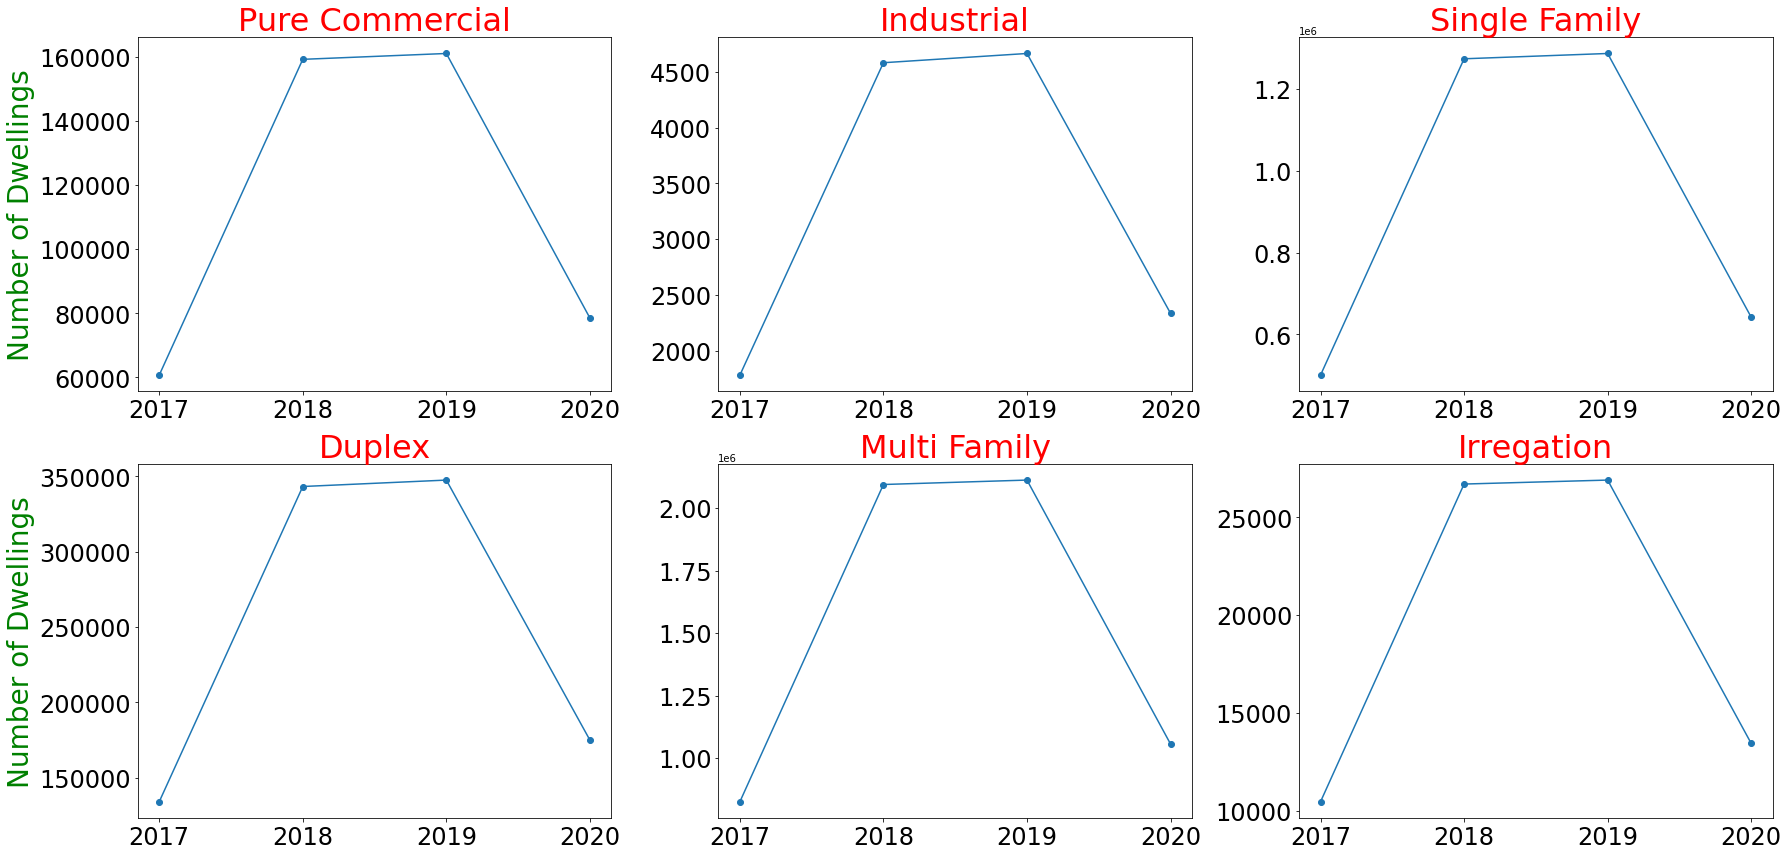

In [13]:
#Plot total number of dwellings in different customer groups
temp = data.groupby([data.RATE,data.year])['DWEL_UNIT'].sum().to_frame()
temp.reset_index(inplace=True)


plt.figure(figsize=(25,12))



ax1 = plt.subplot2grid((2,3), (0, 0))
ax2 = plt.subplot2grid((2,3), (0, 1))
ax3 = plt.subplot2grid((2,3), (0, 2))
ax4 = plt.subplot2grid((2,3), (1, 0))
ax5 = plt.subplot2grid((2,3), (1, 1))
ax6 = plt.subplot2grid((2,3), (1, 2))


plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

com = temp[temp['RATE'] == 'COM']
ax1.plot(com.year, com.DWEL_UNIT, marker='o')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_ylabel('Number of Dwellings',fontsize=28, c= 'green')
ax1.set_title('Pure Commercial',fontsize=32, c= 'red')


industrial = temp[temp['RATE'] == 'IND']
ax2.plot(industrial.year, industrial.DWEL_UNIT, marker='o')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.set_title('Industrial',fontsize=32, c= 'red')
ax2.set_xticks(industrial.year)

singlef = temp[temp['RATE'] == 'RSFD']
ax3.plot(singlef.year, singlef.DWEL_UNIT, marker='o')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.set_title('Single Family',fontsize=32, c= 'red')

duplex = temp[temp['RATE'] == 'RDUPLX']
ax4.plot(duplex.year, duplex.DWEL_UNIT, marker='o')
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.set_ylabel('Number of Dwellings',fontsize=28, c= 'green')
ax4.set_title('Duplex',fontsize=32, c= 'red')

multif = temp[temp['RATE'] == 'RMF']
ax5.plot(multif.year, multif.DWEL_UNIT, marker='o')
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.set_title('Multi Family',fontsize=32, c= 'red')


irr = temp[temp['RATE'] == 'IRR']
ax6.plot(irr.year, irr.DWEL_UNIT, marker='o')
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.set_title('Irregation',fontsize=32, c= 'red')


plt.tight_layout()

plt.show()

In [14]:
import calendar
data['days_in_month'] = data[['year', 'month']].apply(lambda x: calendar.monthrange(x[0], x[1])[1], axis=1)

#Find average daily usage in each month
data['avg_daily_usage'] = data[['usage','days_in_month' ]].apply(lambda x: round(x[0] / x[1],2), axis=1)
data.head()

RATE month_start  DWEL_UNIT     usage  year  month  days_in_month  \
11  COM  2017-08-01      11933  517040.4  2017      8             31   
12  COM  2017-09-01      11837  444599.4  2017      9             30   
13  COM  2017-10-01      13028  483258.2  2017     10             31   
14  COM  2017-11-01      11916  411534.7  2017     11             30   
15  COM  2017-12-01      11998  404455.6  2017     12             31   

    avg_daily_usage  
11         16678.72  
12         14819.98  
13         15588.97  
14         13717.82  
15         13046.95

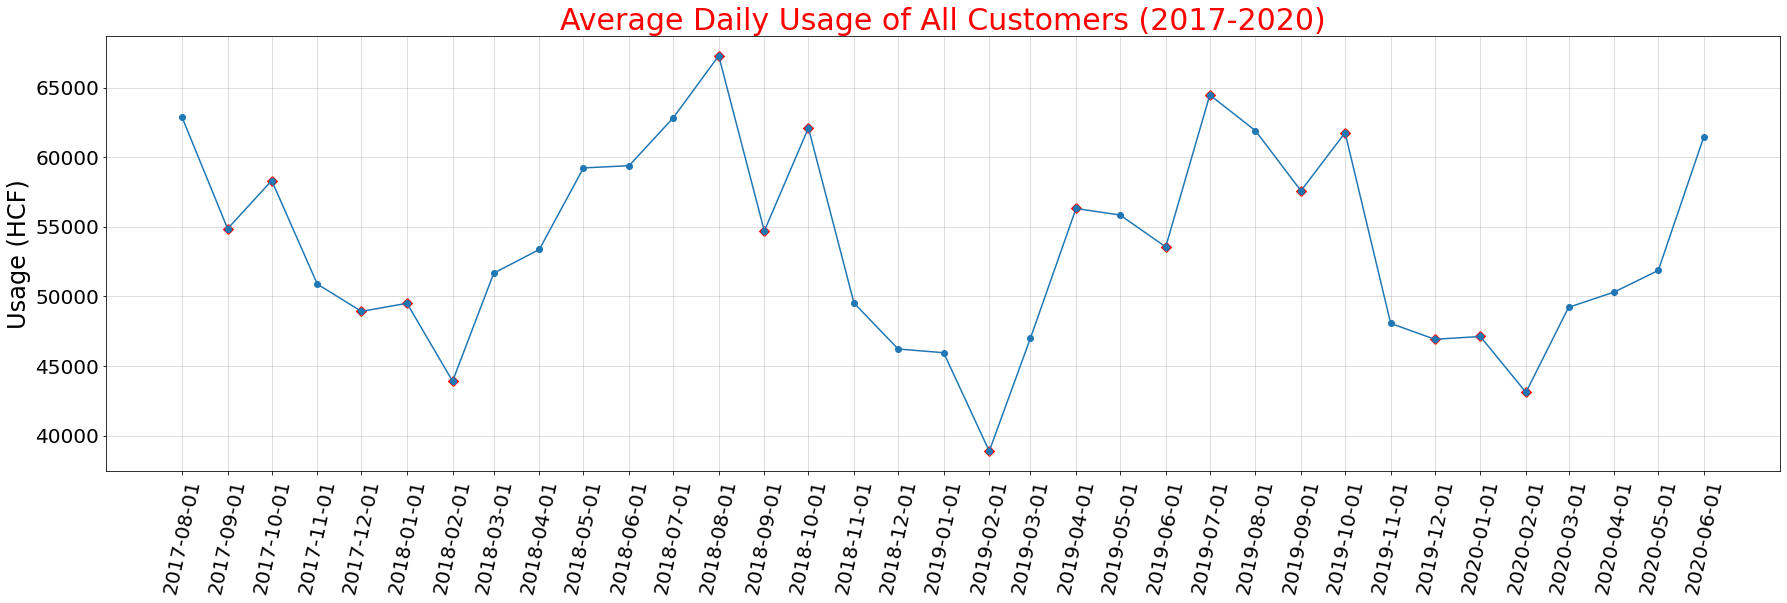

In [15]:
#Plot the water consumpotion from 2017 to 2020 for all customers
plt.figure(figsize=(30,8))
temp = data.groupby('month_start')['avg_daily_usage'].sum().reset_index()
plt.plot(temp.month_start, temp.avg_daily_usage, marker='o')


Y=np.array(temp.avg_daily_usage)
maxInd = argrelextrema(Y, np.greater)
minInd = argrelextrema(Y, np.less)

X=np.array(temp.month_start)
max_loc = X[maxInd]
min_loc = X[minInd]

plt.scatter(x= max_loc, y= Y[maxInd], c='red', s=50, marker='D')
plt.scatter(x= min_loc, y= Y[minInd], c='red', s=50, marker='D')

#Add corresponding grid
plt.grid(which='both')

#Set different settings for the grids
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)
plt.xticks(temp.month_start, fontsize=20, rotation=78)
plt.ylabel('Usage (HCF)',fontsize= 24)
plt.yticks(fontsize=20)
plt.title('Average Daily Usage of All Customers (2017-2020)', fontsize=30, c='red')


plt.show()


**Average daily usage in Feb 2018,2019 and 2020 were the minimum. The reason might be related to number of days in Feb (Feb 2017,2018,2019 had 28 days and Feb2020 had 29 days).**

**June and July demonstrate the relatively high usage in years of 2017,2018 and 2019, the increase in water consumption is due to summer season. Also, Nov, Dec and Feb show decrease in usage,so there is a seasonality.**

**In 2020, water usage decreased from March 2020 and continue until June compared with similar months inprevious years.**

**Besides seasonality, there is a trend that seems it is not kept in 2020.**

In [16]:
avg_usage_2017 = data[data.year == 2017]
avg_usage_2018 = data[data.year == 2018]
avg_usage_2019 = data[data.year == 2019]
avg_usage_2020 = data[data.year == 2020]

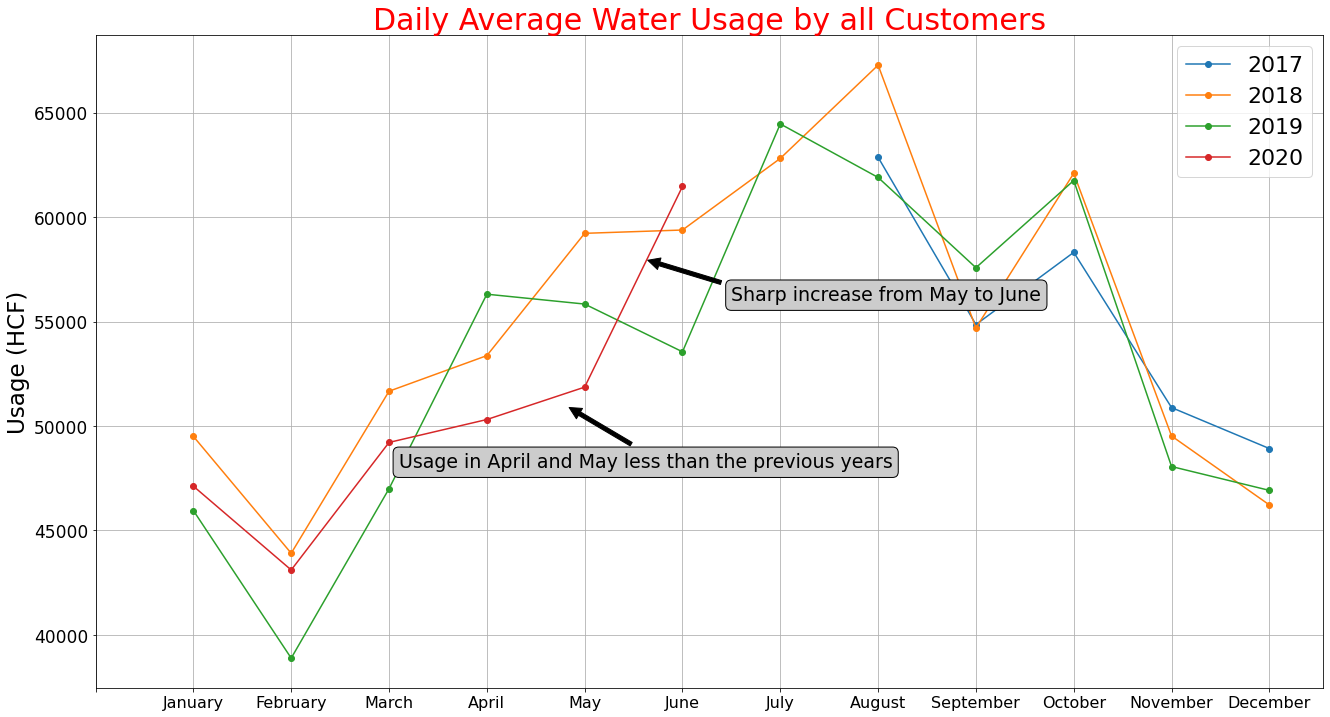

In [17]:
avg_usage_2017 = avg_usage_2017.groupby('month')['avg_daily_usage'].sum().reset_index()
avg_usage_2018 = avg_usage_2018.groupby('month')['avg_daily_usage'].sum().reset_index()
avg_usage_2019 = avg_usage_2019.groupby('month')['avg_daily_usage'].sum().reset_index()
avg_usage_2020 = avg_usage_2020.groupby('month')['avg_daily_usage'].sum().reset_index()

plt.figure(figsize=(22,12))
plt.plot(avg_usage_2017.month, avg_usage_2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(avg_usage_2018.month, avg_usage_2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(avg_usage_2019.month, avg_usage_2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(avg_usage_2020.month, avg_usage_2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 16)
plt.yticks(fontsize= 17)
plt.ylabel('Usage (HCF)', fontsize= 23)
plt.legend(fontsize= 22)
plt.grid(which= 'both')
plt.title('Daily Average Water Usage by all Customers', fontsize= 30, c='red')

#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Usage in April and May less than the previous years', xytext= (3.1,48000), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(4.8,51000),\
             fontsize=19, c='black')

plt.annotate('Sharp increase from May to June', xytext= (6.5,56000), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.6,58000),\
             fontsize=19, c='black')

plt.show()

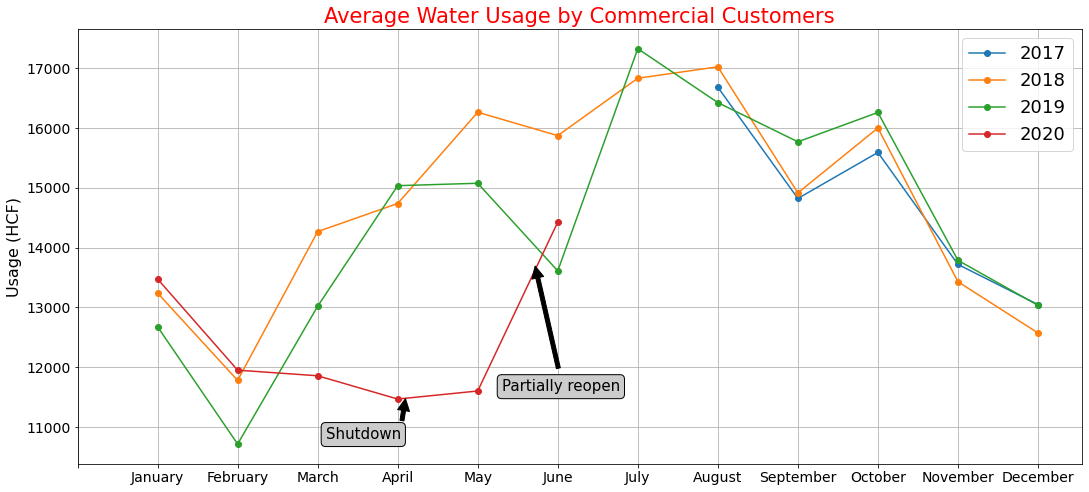

In [18]:
#Commercial customers
com = data[data['RATE'] == 'COM']
com = com.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
com2017 = com[com.year == 2017]
com2018 = com[com.year == 2018]
com2019 = com[com.year == 2019]
com2020 = com[com.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(com2017.month, com2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(com2018.month, com2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(com2019.month, com2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(com2020.month, com2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend(fontsize= 18)
plt.grid(which= 'both')
plt.title('Average Water Usage by Commercial Customers', fontsize= 21, c='red')


#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Shutdown', xytext= (3.1,10800), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(4.1,11500),\
             fontsize= 15, c='black')
plt.annotate('Partially reopen', xytext= (5.3,11600), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.7,13790),\
             fontsize= 15, c='black')

plt.show()

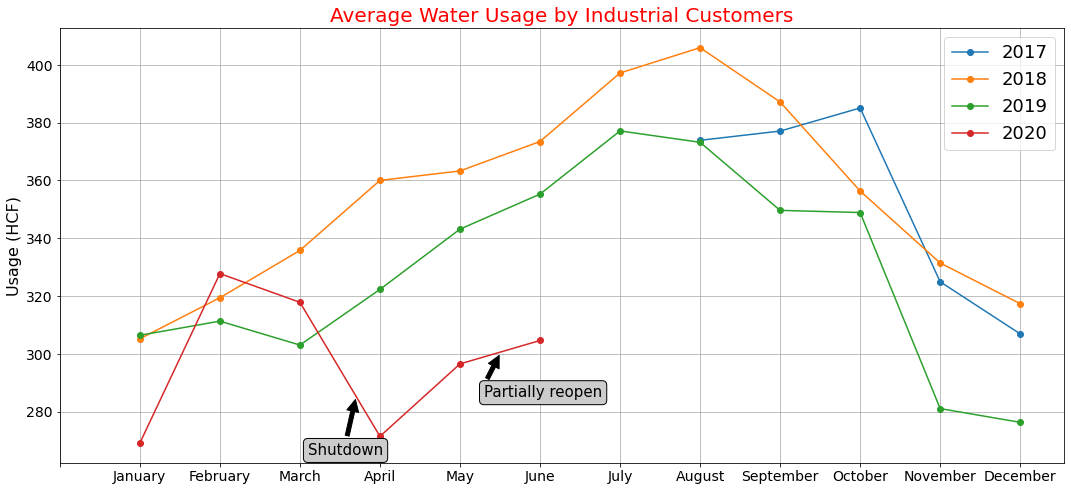

In [19]:
#Industrial customers
industrial = data[data['RATE'] == 'IND']
industrial = industrial.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
industrial2017 = industrial[industrial.year == 2017]
industrial2018 = industrial[industrial.year == 2018]
industrial2019 = industrial[industrial.year == 2019]
industrial2020 = industrial[industrial.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(industrial2017.month, industrial2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(industrial2018.month, industrial2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(industrial2019.month, industrial2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(industrial2020.month, industrial2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend(fontsize= 18)
plt.grid(which= 'both')
plt.title('Average Water Usage by Industrial Customers', fontsize= 20, c='red')


#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Shutdown', xytext= (3.1,265), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(3.7,285),\
             fontsize= 15, c='black')
plt.annotate('Partially reopen', xytext= (5.3,285), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.5,300),\
             fontsize= 15, c='black')

plt.show()

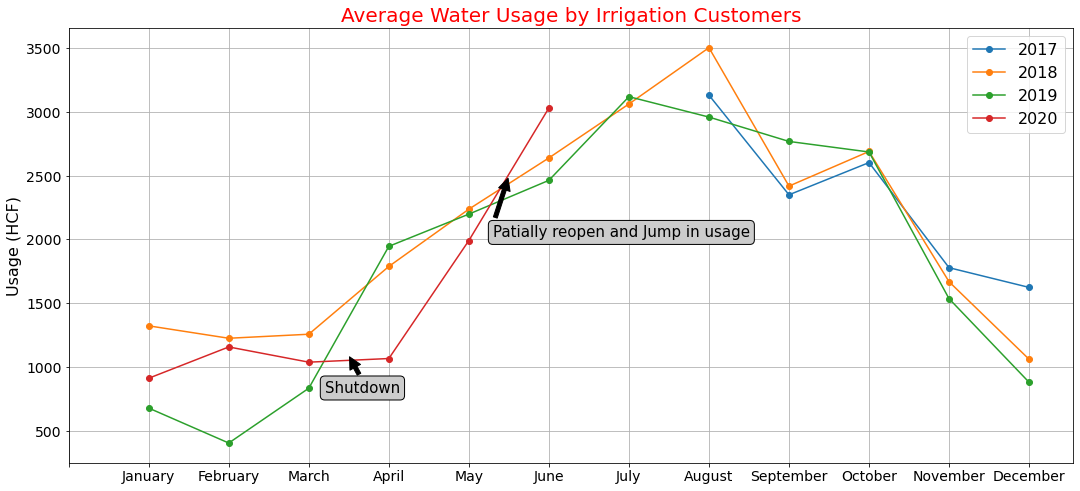

In [20]:
#Irrigation customers
irr = data[data['RATE'] == 'IRR']
irr = irr.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
irr2017 = irr[irr.year == 2017]
irr2018 = irr[irr.year == 2018]
irr2019 = irr[irr.year == 2019]
irr2020 = irr[irr.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(irr2017.month, irr2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(irr2018.month, irr2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(irr2019.month, irr2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(irr2020.month, irr2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend( fontsize= 16)
plt.grid(which= 'both')
plt.title('Average Water Usage by Irrigation Customers', fontsize= 20, c='red')

#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Shutdown', xytext= (3.2,800), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(3.5,1090),\
             fontsize= 15, c='black')
plt.annotate('Patially reopen and Jump in usage', xytext= (5.3,2020), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.5,2500),\
             fontsize= 15, c='black')

plt.show()

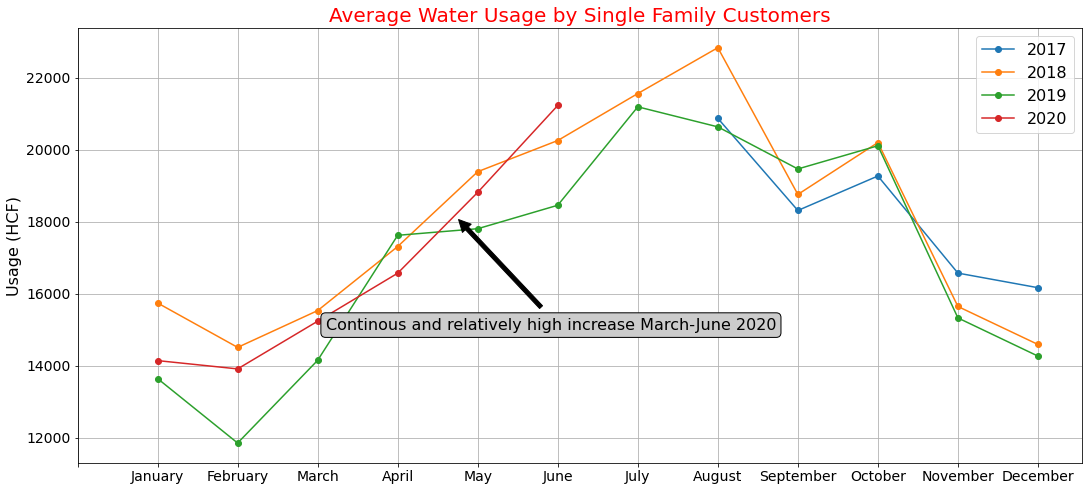

In [21]:
#Single Family customers
singlef = data[data['RATE'] == 'RSFD']
singlef = singlef.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
singlef2017 = singlef[singlef.year == 2017]
singlef2018 = singlef[singlef.year == 2018]
singlef2019 = singlef[singlef.year == 2019]
singlef2020 = singlef[singlef.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(singlef2017.month, singlef2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(singlef2018.month, singlef2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(singlef2019.month, singlef2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(singlef2020.month, singlef2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend( fontsize= 16)
plt.grid(which= 'both')
plt.title('Average Water Usage by Single Family Customers', fontsize= 20, c='red')

#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Continous and relatively high increase March-June 2020', xytext= (3.1,15000), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(4.7,18200),\
             fontsize= 16, c='black')

plt.show()

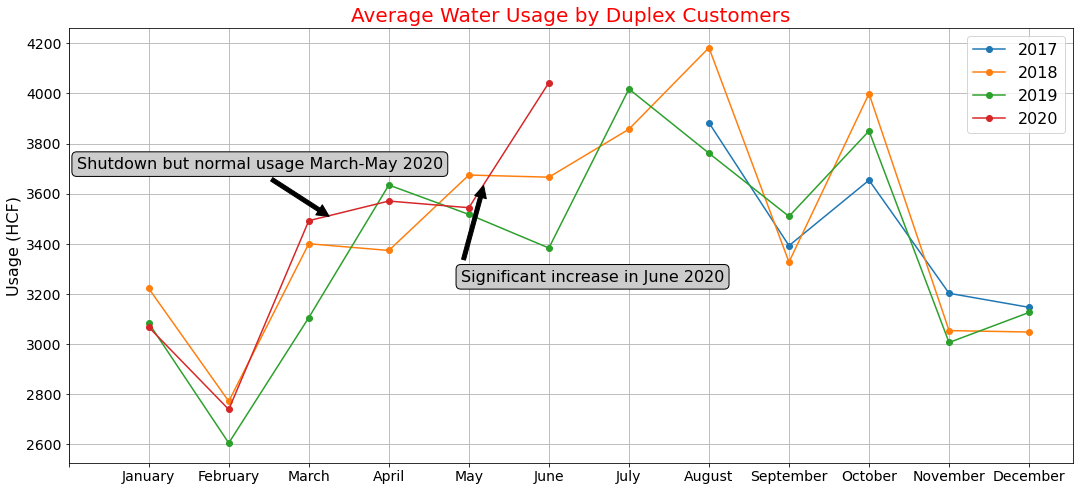

In [22]:
#Duplex customers
duplex = data[data['RATE'] == 'RDUPLX']
duplex = duplex.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
duplex2017 = duplex[duplex.year == 2017]
duplex2018 = duplex[duplex.year == 2018]
duplex2019 = duplex[duplex.year == 2019]
duplex2020 = duplex[duplex.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(duplex2017.month, duplex2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(duplex2018.month, duplex2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(duplex2019.month, duplex2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(duplex2020.month, duplex2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend( fontsize= 16)
plt.grid(which= 'both')
plt.title('Average Water Usage by Duplex Customers', fontsize= 20, c='red')

#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Shutdown but normal usage March-May 2020', xytext= (0.1,3700), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(3.3,3500),\
             fontsize= 16, c='black')

plt.annotate('Significant increase in June 2020', xytext= (4.9,3250), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.2,3650),\
             fontsize= 16, c='black')


plt.show()

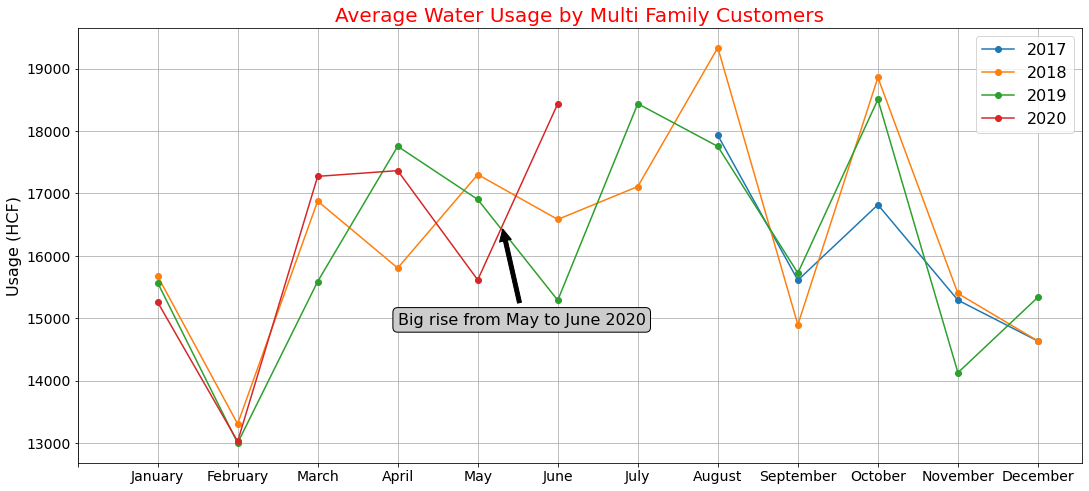

In [23]:
#Multi family customers
multif = data[data['RATE'] == 'RMF']
multif = multif.groupby(['year','month'])['avg_daily_usage'].sum().reset_index()
multif2017 = multif[multif.year == 2017]
multif2018 = multif[multif.year == 2018]
multif2019 = multif[multif.year == 2019]
multif2020 = multif[multif.year == 2020]

plt.figure(figsize=(18,8))
plt.plot(multif2017.month, multif2017.avg_daily_usage, marker='o', label= '2017')
plt.plot(multif2018.month, multif2018.avg_daily_usage, marker='o', label= '2018')
plt.plot(multif2019.month, multif2019.avg_daily_usage, marker='o', label= '2019')
plt.plot(multif2020.month, multif2020.avg_daily_usage, marker='o', label= '2020')
plt.xticks(list(range(13)), calendar.month_name, fontsize= 14)
plt.yticks(fontsize= 14)
plt.ylabel('Usage (HCF)', fontsize= 16)
plt.legend( fontsize= 16)
plt.grid(which= 'both')
plt.title('Average Water Usage by Multi Family Customers', fontsize= 20, c='red')

#Add a text callout with arrow
bbox = dict(boxstyle ="round", fc ="0.8")
plt.annotate('Big rise from May to June 2020', xytext= (4,14900), bbox = bbox,\
             arrowprops = dict(facecolor ='black', shrink = 0.05), xy=(5.3,16500),\
             fontsize= 16, c='black')


plt.show()

C:\Users\bahra\Anaconda\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



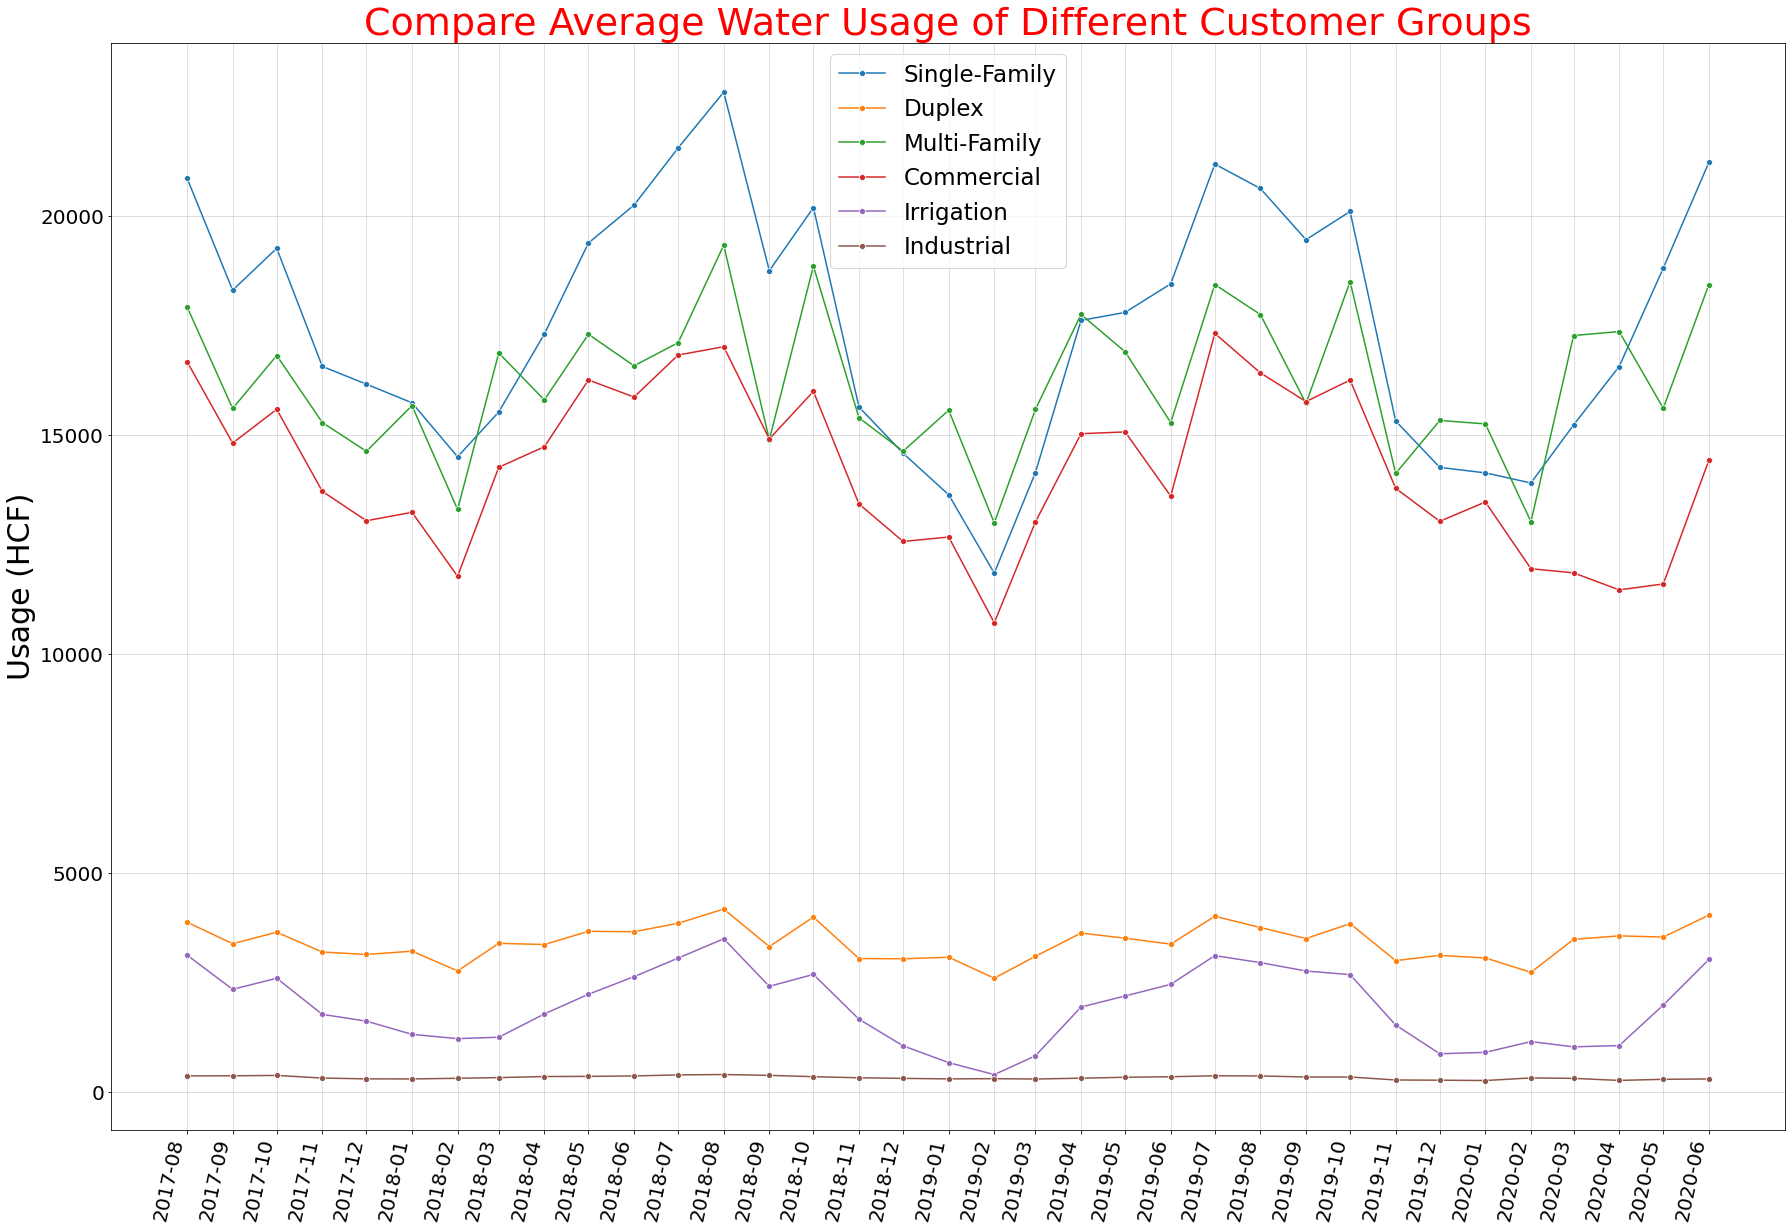

In [24]:
#plot Avg daily water usage of Different Customer Groups
plt.figure(figsize=(30,20))
irr = data[data['RATE'] == 'IRR']
com = data[(data['RATE'] == 'COM') | (data['RATE'] == 'COM&RES')]
com.RATE = 'COM'
industrial = data[data['RATE'] == 'IND']
singlef = data[data['RATE'] == 'RSFD']
duplex = data[data['RATE'] == 'RDUPLX']
multif = data[data['RATE'] == 'RMF']

ax = sns.lineplot(singlef.month_start, singlef.avg_daily_usage, marker='o', label= 'Single-Family')
sns.lineplot(duplex.month_start, duplex.avg_daily_usage, marker='o', label='Duplex')
sns.lineplot(multif.month_start, multif.avg_daily_usage, marker="o", label='Multi-Family')
sns.lineplot(com.month_start, com.avg_daily_usage, marker='o',label='Commercial')
sns.lineplot(irr.month_start, irr.avg_daily_usage, marker="o", label='Irrigation')
sns.lineplot(industrial.month_start, industrial.avg_daily_usage, marker='o', label='Industrial')

ax.set(xticks= irr.month_start)
ax.set_xticklabels(irr.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax.set_xlabel('')
ax.set_ylabel('Usage (HCF)',fontsize = 30)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)

ax.legend(prop=dict(size=19))
ax.set_title('Compare Average Water Usage of Different Customer Groups',fontsize = 38, c='red')



#Add corresponding grid
plt.grid(which='both')

#Set different settings for the grids
plt.grid(which='minor', alpha=0.2)
plt.grid(which='major', alpha=0.5)

plt.legend(fontsize= 23)
plt.show()

**Single-Family and Multi-Family usage tried to offset the decrease in Commercial usage after March 2020.**

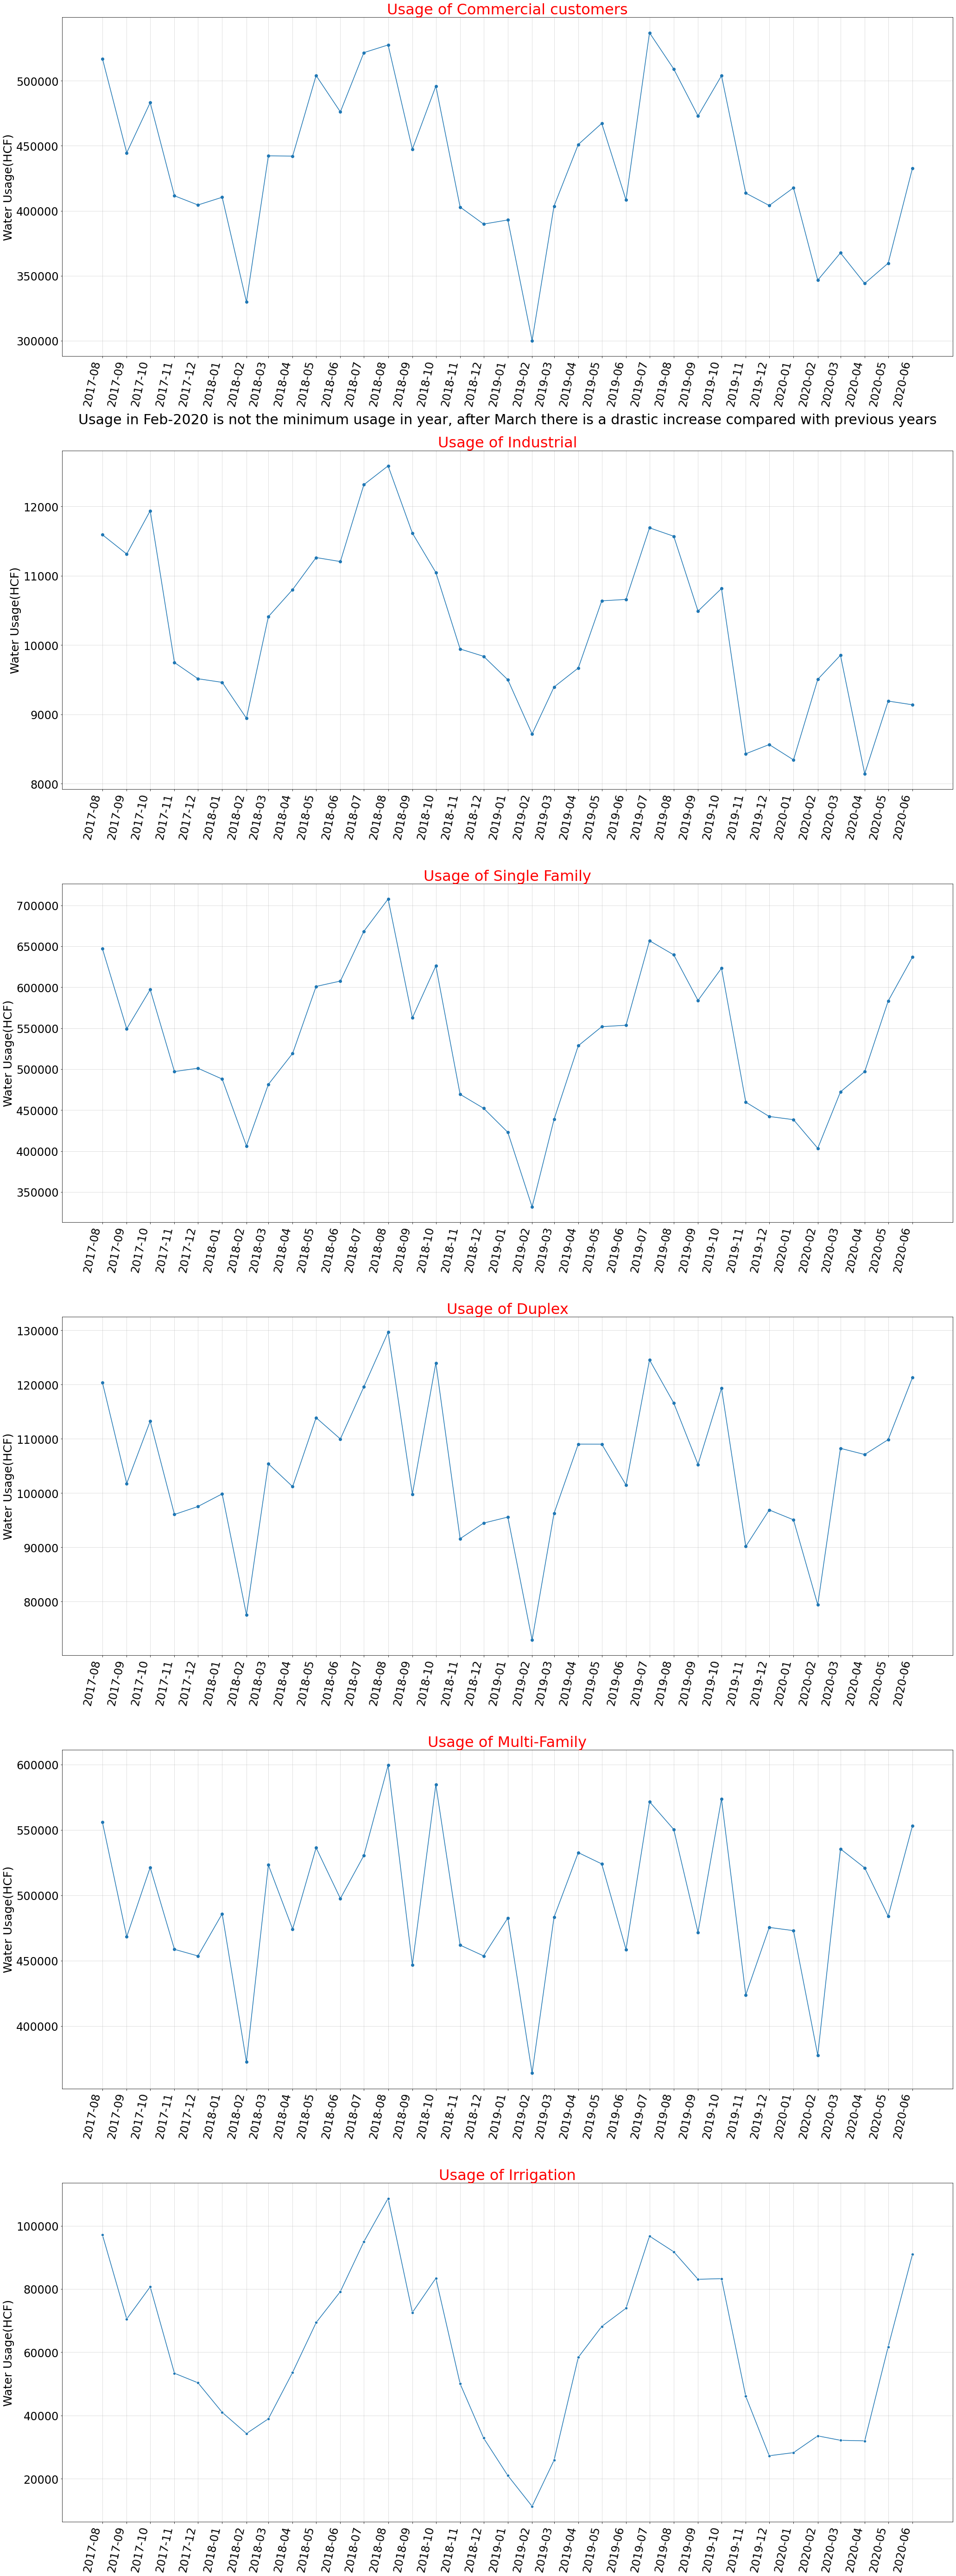

In [25]:
plt.figure(figsize=(30,78))

ax1 = plt.subplot2grid((6,1), (0, 0))
ax2 = plt.subplot2grid((6,1), (1, 0))
ax3 = plt.subplot2grid((6,1), (2, 0))
ax4 = plt.subplot2grid((6,1), (3, 0))
ax5 = plt.subplot2grid((6,1), (4, 0))
ax6 = plt.subplot2grid((6,1), (5, 0))



from scipy.signal import argrelextrema

plt.gcf().subplots_adjust(bottom=0.8)

#Commercial customers
com = data[data['RATE'] == 'COM']
ax1.plot(com.month_start, com.usage, marker='o', label='Pure Commercial')
ax1.set(xticks= com.month_start)
ax1.set_xticklabels(com.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_ylabel('Water Usage(HCF)', fontsize=25)
ax1.set_title('Usage of Commercial customers',fontsize=32, c= 'red')
#Add corresponding grid
ax1.grid(which='both')
#Set different settings for the grids
ax1.grid(which='minor', alpha=0.2)
ax1.grid(which='major', alpha=0.5)

ax1.text(0.5,-.2,\
   'Usage in Feb-2020 is not the minimum usage in year, after March there is a drastic increase compared with previous years',\
         size=30, ha="center", transform=ax1.transAxes)
#ax1.text(0.5,-.5,\
  #  'There is a trend in usage but it does not continue in 2020. Usage drasticallly decreased from June unlike the previous years.',\
   #      size=30, ha="center", 
   #      transform=ax1.transAxes)




#Industrial customers
industrial = data[data['RATE'] == 'IND']
ax2.plot(industrial.month_start, industrial.usage, marker='o')
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.set(xticks= industrial.month_start)
ax2.set_xticklabels(industrial.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax2.set_ylabel('Water Usage(HCF)', fontsize=25)
ax2.set_title('Usage of Industrial',fontsize=32, c= 'red')
#Add corresponding grid
ax2.grid(which='both')
#Set different settings for the grids
ax2.grid(which='minor', alpha=0.2)
ax2.grid(which='major', alpha=0.5)
#ax2.text(0.5,-.4,\
  #  'There is a trend and seasonality from 2017 to 2019.',\
   #      size=30, ha="center", transform=ax3.transAxes)


#Single family
singlef = data[data['RATE'] == 'RSFD']
ax3.plot(singlef.month_start, singlef.usage, marker='o')
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.set(xticks= singlef.month_start)
ax3.set_xticklabels(singlef.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax3.set_ylabel('Water Usage(HCF)', fontsize=25)
ax3.set_title('Usage of Single Family',fontsize=32, c= 'red')
#Add corresponding grid
ax3.grid(which='both')
#Set different settings for the grids
ax3.grid(which='minor', alpha=0.2)
ax3.grid(which='major', alpha=0.5)






#Duplex
duplex = data[data['RATE'] == 'RDUPLX']
ax4.plot(duplex.month_start, duplex.usage, marker='o')
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.set(xticks= duplex.month_start)
ax4.set_xticklabels(duplex.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax4.set_ylabel('Water Usage(HCF)', fontsize=25)
ax4.set_title('Usage of Duplex',fontsize=32, c= 'red')
#Add corresponding grid
ax4.grid(which='both')
#Set different settings for the grids
ax4.grid(which='minor', alpha=0.2)
ax4.grid(which='major', alpha=0.5)






#Multi family
multif = data[data['RATE'] == 'RMF']
ax5.plot(multif.month_start, multif.usage, marker="o")
ax5.set(xticks= multif.month_start)
ax5.set_xticklabels(multif.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.set_xticklabels(multif.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax5.set_ylabel('Water Usage(HCF)', fontsize=25)
ax5.set_title('Usage of Multi-Family',fontsize=32, c= 'red')
#Add corresponding grid
ax5.grid(which='both')
#Set different settings for the grids
ax5.grid(which='minor', alpha=0.2)
ax5.grid(which='major', alpha=0.5)




#Irrigation
irr = data[data['RATE'] == 'IRR']
ax6 = sns.lineplot(irr.month_start, irr.usage, marker="o")
ax6.set(xticks= irr.month_start)
ax6.set_xlabel('')
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.set_xticklabels(irr.month_start.dt.strftime('%Y-%m'), rotation=78, horizontalalignment='right')
ax6.set_ylabel('Water Usage(HCF)', fontsize=25)
ax6.set_title('Usage of Irrigation',fontsize=32, c= 'red')
#Add corresponding grid
ax6.grid(which='both')
#Set different settings for the grids
ax6.grid(which='minor', alpha=0.2)
ax6.grid(which='major', alpha=0.5)


plt.tight_layout() 
plt.show()